# Sentence Transformers (a.k.a. SBERT) 

SBERT is the go-to Python module for accessing, using, and training state-of-the-art text and image embedding models. It can be used 
- to compute embeddings using Sentence Transformer models ([quikstart](https://sbert.net/docs/quickstart.html#sentence-transformer)) or 
- to calculate similarity scores using Cross-Encoder models ([quickstart](https://sbert.net/docs/quickstart.html#cross-encoder)). 

This unlocks a wide range of applications, including semantic search, semantic textual similarity, and paraphrase mining.

A wide selection of over 5,000 pre-trained Sentence Transformers models are available for immediate use on 🤗 Hugging Face, including many of the state-of-the-art models from the Massive Text Embeddings Benchmark (MTEB) leaderboard. Additionally, it is easy to train or finetune your own models using Sentence Transformers, enabling you to create custom models for your specific use cases.


In [3]:
# 使用清华大学镜像快速安装Python包 
pip install -i https://pypi.tuna.tsinghua.edu.cn/simple -U sentence-transformers

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 KB 1.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 MB 6.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 11.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.5/417.5 KB 8.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.3/416.3 KB 8.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 11.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: fsspec
    Found existing installation: fsspec 0.9.0
    Uninstalling fsspec-0.9.0:
      Successfully uninstalled fsspec-0.9.0
You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install -U huggingface_hub -i https://pypi.tuna.tsinghua.edu.cn/simple/

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple/
You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
# you must run this first
import os
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'

## Sentence Transformer
Characteristics of Sentence Transformer (a.k.a bi-encoder) models:

- Calculates a fixed-size vector representation (embedding) given texts or images.
- Embedding calculation is often efficient, embedding similarity calculation is very fast.
- Applicable for a wide range of tasks, such as semantic textual similarity, semantic search, clustering, classification, paraphrase mining, and more.
- Often used as a first step in a two-step retrieval process, where a Cross-Encoder (a.k.a. reranker) model is used to re-rank the top-k results from the bi-encoder.

In [23]:
from sentence_transformers import SentenceTransformer

# 1. Load a pretrained Sentence Transformer model
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

In [24]:
# The sentences to encode
sentences = [
    "The weather is lovely today.",
    "It's so sunny outside!",
    "He drove to the stadium.",
]

# 2. Calculate embeddings by calling model.encode()
embeddings = model.encode(sentences)
print(embeddings.shape)

(3, 384)


In [18]:
e1 = model.encode('woman')
e2 = model.encode('man')

model.similarity(e1, e2)

tensor([[0.3257]])

In [30]:
from numpy import dot  #Dot product#
from numpy.linalg import norm
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial


def cos_sim(a, b):
    return dot(a, b)/(norm(a)*norm(b))

def cos(x, y):
    return 1 - spatial.distance.cosine(x, y)

def nrm(x):
    # Normalize vector#
    return x/norm(x)

def dimension(x, y):
    # Calculate semantic dimension from antonym pair#
    return nrm(nrm(x)-nrm(y))

In [26]:
###IMPORT LISTS OF TERMS TO PROJECT AND ANTONYM PAIRS#####
import pandas as pd
ant_pairs_aff = pd.read_csv("../data/word_pairs/affluence_pairs.csv",header=None)
ant_pairs_gen = pd.read_csv("../data/word_pairs/gender_pairs.csv",header=None)
ant_pairs_race = pd.read_csv("../data/word_pairs/race_pairs.csv",header=None)

In [28]:
def make_dim(model, df):
    word_dims = []
    for i in df.index:
        rp_word1 = df[0][i]
        rp_word2 = df[1][i]
        try:
            word_dims.append( dimension(model.encode(rp_word1), model.encode(rp_word2)) )
        except:
            pass
    dim_ave = pd.DataFrame(word_dims).mean().tolist()
    dim_ave_= nrm(dim_ave)
    return dim_ave

In [31]:
aff_dim = make_dim(model, ant_pairs_aff)
gender_dim = make_dim(model, ant_pairs_gen)
race_dim = make_dim(model, ant_pairs_race)

In [33]:
wlist=["camping","baseball","boxing","volleyball","softball",
       "badminton", "golf","tennis","soccer","basketball","hockey"]

aff_proj = [cos(aff_dim, model.encode(i)) for i in wlist]
gender_proj = [cos(gender_dim, model.encode(i)) for i in wlist]
race_proj = [cos(race_dim, model.encode(i)) for i in wlist]

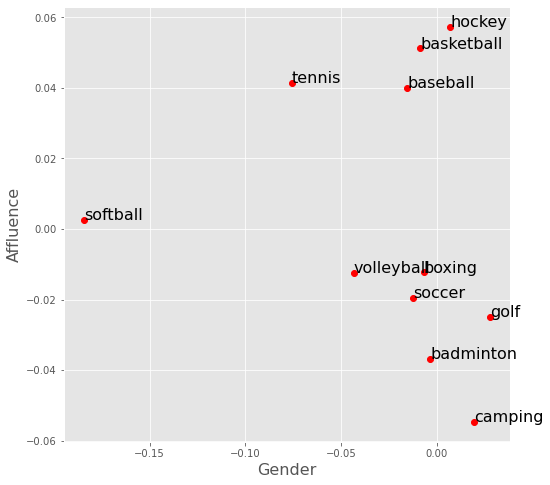

In [35]:
# plot
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

plt.figure(figsize  = [8, 8])
plt.plot(gender_proj, aff_proj, 'ro')
for k, i in enumerate(wlist):
    plt.text(gender_proj[k], aff_proj[k], i, fontsize = 16)
#plt.xlim([-0.25, 0.25])
#plt.ylim([-0.25, 0.25])
plt.xlabel('Gender', fontsize = 16)
plt.ylabel('Affluence', fontsize = 16)

plt.show()

In [8]:
embeddings[0]

array([ 1.91957615e-02,  1.20085381e-01,  1.59598336e-01,  6.70658946e-02,
        5.00748530e-02, -2.59187464e-02,  5.64681962e-02, -9.28578228e-02,
       -3.76114659e-02,  6.32382883e-03, -4.28877510e-02,  4.02827654e-03,
        4.72778594e-03,  3.24676596e-02,  4.95197512e-02,  5.29818423e-02,
       -4.04454656e-02, -2.14837510e-02, -3.02760620e-02,  2.20858715e-02,
       -1.60775796e-01,  8.08077976e-02, -2.80131046e-02,  8.06255564e-02,
       -2.85814162e-02,  5.35818227e-02,  1.26382494e-02,  4.79190759e-02,
        5.71115315e-03, -3.25830951e-02, -2.61571389e-02,  8.00957829e-02,
        1.47315757e-02, -3.24082188e-02, -4.12551947e-02, -9.68342740e-03,
        5.00810973e-04, -1.56286806e-01, -6.77877441e-02,  4.88779247e-02,
        1.88976023e-02, -7.97722116e-02,  2.43868101e-02,  5.46692871e-03,
        1.10656964e-02, -7.77951488e-03, -2.20388379e-02,  3.50319780e-02,
        1.06080189e-01, -4.72450536e-03, -5.78185692e-02,  2.34566033e-02,
       -5.92035986e-02, -

In [6]:
# 3. Calculate the embedding similarities
similarities = model.similarity(embeddings, embeddings)
print(similarities)

tensor([[1.0000, 0.6660, 0.1046],
        [0.6660, 1.0000, 0.1411],
        [0.1046, 0.1411, 1.0000]])


## Cross Encoder
Characteristics of Cross Encoder (a.k.a reranker) models:

- Calculates a similarity score given pairs of texts.
- Generally provides superior performance compared to a Sentence Transformer (a.k.a. bi-encoder) model.
- Often slower than a Sentence Transformer model, as it requires computation for each pair rather than each text.

Due to the previous 2 characteristics, Cross Encoders are often used to re-rank the top-k results from a Sentence Transformer model.

The usage for Cross Encoder (a.k.a. reranker) models is similar to Sentence Transformers:

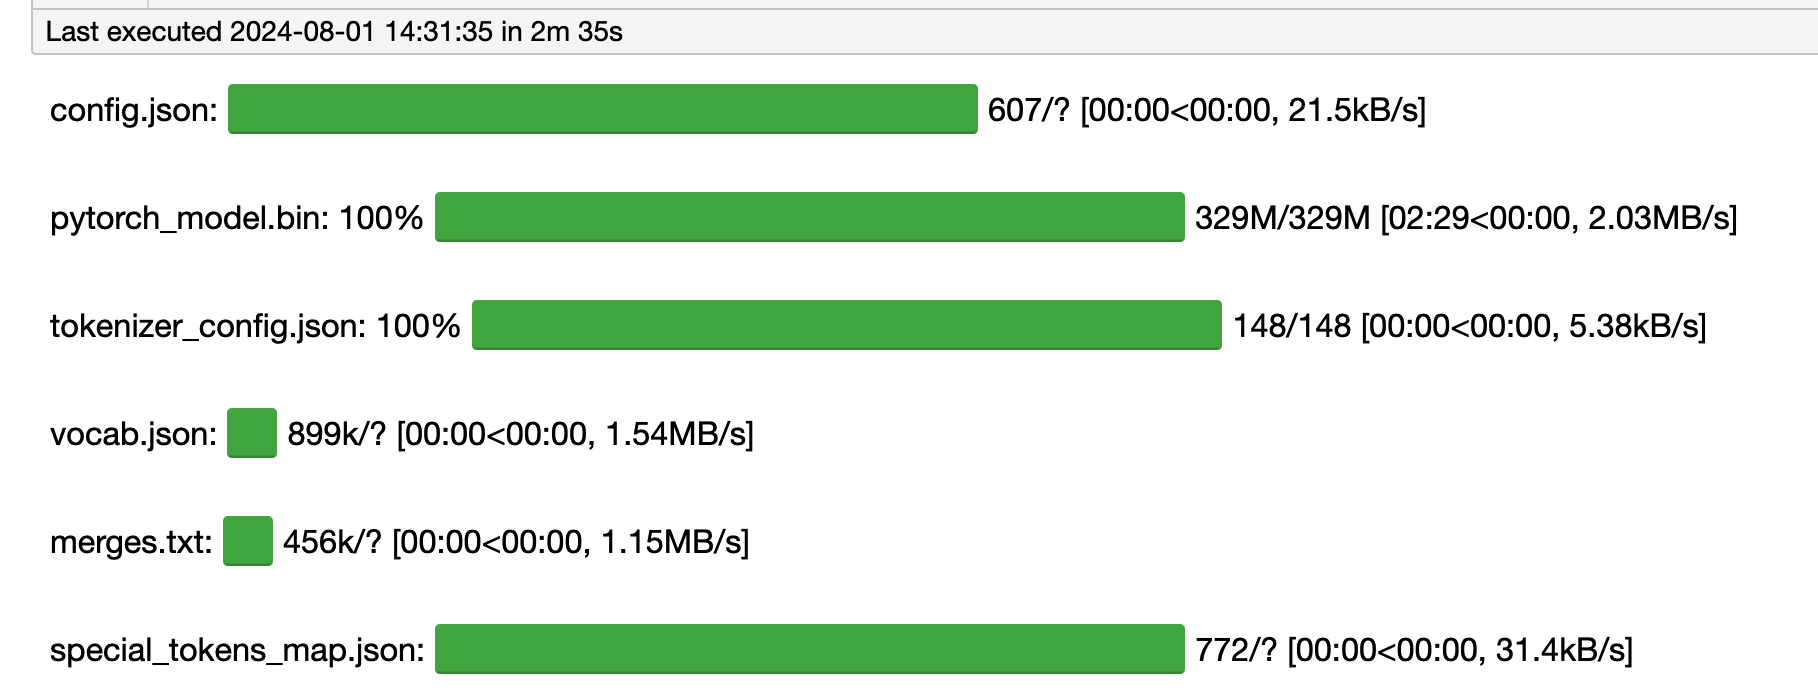

In [19]:
from sentence_transformers.cross_encoder import CrossEncoder

# 1. Load a pretrained CrossEncoder model
model = CrossEncoder("cross-encoder/stsb-distilroberta-base")

In [20]:
# We want to compute the similarity between the query sentence...
query = "A man is eating pasta."

# ... and all sentences in the corpus
corpus = [
    "A man is eating food.",
    "A man is eating a piece of bread.",
    "The girl is carrying a baby.",
    "A man is riding a horse.",
    "A woman is playing violin.",
    "Two men pushed carts through the woods.",
    "A man is riding a white horse on an enclosed ground.",
    "A monkey is playing drums.",
    "A cheetah is running behind its prey.",
]


In [21]:
# 2. We rank all sentences in the corpus for the query
ranks = model.rank(query, corpus)

# Print the scores
print("Query: ", query)
for rank in ranks:
    print(f"{rank['score']:.2f}\t{corpus[rank['corpus_id']]}")

Query:  A man is eating pasta.
0.67	A man is eating food.
0.34	A man is eating a piece of bread.
0.08	A man is riding a horse.
0.07	A man is riding a white horse on an enclosed ground.
0.01	The girl is carrying a baby.
0.01	Two men pushed carts through the woods.
0.01	A monkey is playing drums.
0.01	A woman is playing violin.
0.01	A cheetah is running behind its prey.


In [22]:
# 3. Alternatively, you can also manually compute the score between two sentences
import numpy as np

sentence_combinations = [[query, sentence] for sentence in corpus]
scores = model.predict(sentence_combinations)

# Sort the scores in decreasing order to get the corpus indices
ranked_indices = np.argsort(scores)[::-1]
print("Scores:", scores)
print("Indices:", ranked_indices)

Scores: [0.6732372  0.34102565 0.00542465 0.07569348 0.00525378 0.00536814
 0.0667624  0.00534824 0.00516718]
Indices: [0 1 3 6 2 5 7 4 8]
